In [15]:
from matplotlib import pyplot as plt
import numpy as np

import seaborn as sns
%matplotlib inline

24.969592783798348


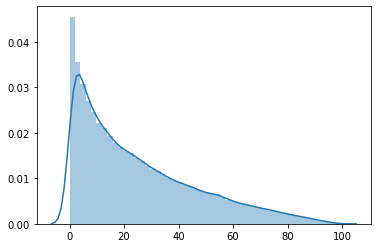

In [21]:
b=1+(np.random.rand(100000)*98)
c=[np.random.rand()*x for x in b]
print( np.mean(c))
sns.distplot(c)

0.24869459024170515


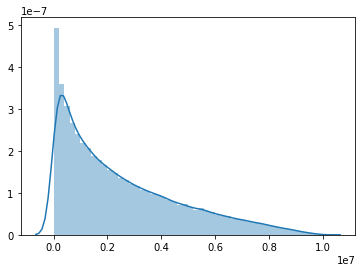

In [20]:
b=np.random.rand(100000)*10000000
c=[np.random.rand()*x for x in b]
print( np.mean(c)/10000000)
sns.distplot(c)

In [13]:
c

[203357.25961637805,
 39841.58944445093,
 225614.13289568954,
 130636.01659748657,
 529406.6898652111,
 646178.2115127069,
 77756.27566080753,
 207628.01572342622,
 82241.67943525728,
 10576.62975066466,
 28942.98179446828,
 855174.5340559061,
 15765.470113348312,
 188555.3860880572,
 263854.12402891513,
 6962.416444210158,
 130927.89496396524,
 17654.662886068953,
 130571.41179904199,
 188834.80866759183,
 554668.3983052577,
 53363.51318200313,
 89226.19270162977,
 420688.37313256273,
 49571.15396767129,
 28352.960230867535,
 132901.55688009234,
 694495.6378065902,
 101077.22287313409,
 17837.536944056763,
 15289.233891727585,
 162475.75623424738,
 190390.99252163837,
 852904.4817270653,
 361826.0861874925,
 827971.1112732833,
 3581.781957734628,
 19317.505379581482,
 760727.2025747703,
 491106.6116839141,
 110323.01496872006,
 58.470476307467884,
 82867.75663202866,
 3190.156831812482,
 259158.94295934777,
 828642.2263745685,
 112745.8776051829,
 500101.35884326603,
 667805.461308590

In [1]:
import os
import datetime
from pathlib import Path
from covid_graphs.country_report import CountryReport, create_report
from pprint import pprint
from covid_graphs.formula import TraceGenerator, FittedFormula,BootstrappedFittedFormula,Formula
from covid_graphs.predictions import CountryPrediction, PredictionEvent, prediction_db
from typing import List, Tuple
from dataclasses import dataclass
import numpy as np
from sklearn.metrics import mean_squared_error,mean_absolute_error,max_error,median_absolute_error

In [2]:
def get_matching_predition(report:CountryReport, prediction:CountryPrediction):
    until_date = prediction.prediction_event.date
    return CountryPrediction(
            prediction_event=PredictionEvent(
                name=f"daily_fit_{until_date.strftime('%Y_%m_%d')}", date=until_date
            ),
            country=report.short_name,
            formula=BootstrappedFittedFormula(until_date=until_date,p_drop=0.1),
        )

In [3]:
def _get_fitted_predictions(report: CountryReport) -> List[CountryPrediction]:
    return [
        CountryPrediction(
            prediction_event=PredictionEvent(
                name=f"daily_fit_{until_date.strftime('%Y_%m_%d')}", date=until_date
            ),
            country=report.short_name,
            formula=FittedFormula(until_date=until_date),
        )
        for until_date in [report.dates[-13], report.dates[-7], report.dates[-1]]
    ]

In [4]:

data_dir=Path("../data/raw")
countries=[x.replace(".data","") for x in os.listdir("../data/raw") if x!=".gitkeep" and x!='download_all.zsh']
countries

['Australia',
 'Austria',
 'Belgium',
 'Canada',
 'Chile',
 'Croatia',
 'Czechia',
 'France',
 'Germany',
 'Iceland',
 'Iran',
 'Israel',
 'Italy',
 'Jordan',
 'Korea',
 'Latvia',
 'Lithuania',
 'Malaysia',
 'Netherlands',
 'Norway',
 'NZ',
 'Portugal',
 'Slovakia',
 'Spain',
 'Switzerland',
 'UK',
 'USA']

In [5]:
# Core code for comparing 2 predictions
def train_date(country_prediction):
    return country_prediction.prediction_event.date
def get_end_date(report):
    return report.dates[-1]
day=datetime.timedelta(days=1)
@dataclass
class Model:
    formula: Formula
    curve: TraceGenerator
    report: CountryReport
    name:str
    def inflexion_date(self):
        #TODO: cannot be done
        return self.curve.start_date+datetime.timespace(days=floor(ib))
        
    def start_date(self):
        return self.curve.start_date
    
    def x(self, date):
        return (date-self.curve.start_date).days
        
        
    def y_test(self, date):
        for i,d in enumerate(self.report.dates):
            if d==date:
                return self.report.cumulative_active[i]
        
    def y_predict(self, date):
        x=self.x(date)
        
        return self.curve.func(x)
        
    def eval(self, start_from: datetime.date, to: datetime.date):
        #print("Evaluating")
        assert start_from>=self.start_date()
        predict=[]
        test=[]
        
        #xs,ys= self.curve.generate_trace(to)
        #for a1,a2 in zip(xs,ys):
        #    print(self.name, a1,a2)
        #print("me start date",self.name, self.start_date())
        for i in range((to-start_from).days+1 ):
            date=start_from+datetime.timedelta(days=i)
            #print("me",self.name,date, self.x(date),self.y_test(date),self.y_predict(date))
            test.append(self.y_test(date))
            predict.append(self.y_predict(date))        
        return np.array(test),np.array(predict)
            
            
def model(cp: CountryPrediction, report:CountryReport,name:str):
    formula = cp.formula
                   
    curve =formula.get_trace_generator(report)

    return Model(formula, curve, report,name)
    
@dataclass    
class ModelMetrics():
    mse: float
    mre:float
    medre:float
        
@dataclass 
class  ModelReport():
    our_train_until:datetime.date
    eval_from:datetime.date
    rk:ModelMetrics
    our:ModelMetrics
        
def metrics(y_true,y_pred):
    
#     relative_difference=np.maximum(
#                 y_pred/y_true,
#                 y_true/y_pred )
    relative_difference=(y_pred-y_true)/y_true 
    
    return ModelMetrics(
        mean_squared_error(
            y_true, 
            y_pred),
        
        mean_absolute_error(
            np.zeros(len(y_true)), 
            relative_difference ),
         median_absolute_error(
            np.zeros(len(y_true)), 
            relative_difference )
    )
def compare_predictions(a:CountryPrediction,b:CountryPrediction,report:CountryReport):
    start_date = max(train_date(a),train_date(b))+day
    end_date = get_end_date(report)
    if end_date<start_date:
        return None
  
    ma=model(a, report,'their')
    mb=model(b, report,'our')
    
    yt, ya=ma.eval(start_date, end_date)
    yt2, yb=mb.eval(start_date, end_date)
    assert(np.array_equal(yt,yt2))
 #   for i in range(len(yt)):
 #       print(start_date+datetime.timedelta(days=i))
 #       print(ya[i])
 #       print(yt[i])
 #       print(yb[i])
        
#    print(metrics(yt,ya))
#    print(metrics(yt,yb))
    return  (
        f'our data until: {train_date(b)}',
        f'eval interval:{start_date},{end_date}',
        "rk:", 
        f't0={ma.start_date()}', 
        metrics(yt, ya),
        "our:",
        f't0={mb.start_date()}', 
        metrics(yt,yb) ),(ya,yt,yb)


#compare_predictions(country_predictions[1],country_predictions[3],country_report)

    

def comparison_for_country(country_name,suf=""):
    country_predictions = prediction_db.predictions_for_country(country=country_name)
    country_report = create_report(data_dir / f"{country_name+suf}.data", short_name=country_name)
    fitted_predictions=_get_fitted_predictions(report=country_report)
    
    for rk in country_predictions[1:]:
        print(f"\nComparing to model from: {rk.prediction_event.date}")
        for our in (fitted_predictions[:-1] +[get_matching_predition(country_report, rk)])[-1:]:
            o=compare_predictions(rk, our, country_report)[0]
            pprint(o)
            
            print(o[-1].mse/o[-4].mse)
            

print(2620587606.8683047/360436892.6317816)            
comparison_for_country("USA") #7.68=1.52212

    

7.270586503322979

Comparing to model from: 2020-04-11
2020-05-18
('our data until: 2020-04-11',
 'eval interval:2020-04-12,2020-04-27',
 'rk:',
 't0=2020-03-10',
 ModelMetrics(mse=360436892.6317816, mre=0.027122342483720648, medre=0.031192647193071542),
 'our:',
 't0=2020-03-02',
 ModelMetrics(mse=3213692564.222109, mre=0.07246143644421218, medre=0.07429218871736407))
8.916103289973655


Comparing to model from: 2020-04-11
2020-05-17
('our data until: 2020-04-11',
 'eval interval:2020-04-12,2020-04-27',
 'rk:',
 't0=2020-03-10',
 ModelMetrics(mse=360436892.6317816, mre=0.027122342483720648, medre=0.031192647193071542),
 'our:',
 't0=2020-02-28',
 ModelMetrics(mse=6652180007.2472, mre=0.114380897791624, medre=0.11616948494380641))
18.45587991472059

In [ ]:
c

In [268]:
# compute inflexion point for USA fit 
alf=6.876271274539387
tg=7.813939904005318
print(tg*(alf-np.sqrt(alf)))

33.24055303929233


In [362]:
# precomputes fits for all pair and all countries
from collections import defaultdict

def measure_countries(smooth=False):
    D=defaultdict(dict)
    for country_name in countries:
        country_predictions = prediction_db.predictions_for_country(country=country_name)
        country_report = create_report(data_dir / f"{country_name}.data", short_name=country_name)
        fitted_predictions=_get_fitted_predictions(report=country_report)

        for rk in country_predictions:
            print(f"\nComparing to model from: {rk.prediction_event.date}")
            for our in (fitted_predictions[:-1] +[get_matching_predition(country_report, rk)]):
                f1,f2 = compare_predictions(rk, our, country_report,smooth)
                D[(rk.prediction_event.date,f1[0])][country_name]=f2
    return D
H_s=measure_countries(smooth=7.68)
#H=measure_countries(smooth=7.68) computed



Comparing to model from: 2020-04-11
AtgModelFit(a=0.005401352350010423, tg=4.560610414893574, exp=10.84767757367095, t0=26.683262990420502)
AtgModelFit(a=6.539015177863623e-05, tg=3.9870007206879787, exp=12.587397260019774, t0=25.21868496658506)
AtgModelFit(a=3.2365917627300925e-06, tg=4.110508781439566, exp=13.77157371056721, t0=20.268231422929116)

Comparing to model from: 2020-04-11
AtgModelFit(a=4.076027265363508e-07, tg=3.6644334155940586, exp=14.735829135541676, t0=19.20007441468152)
AtgModelFit(a=2.3206230051718493e-07, tg=3.6137003198714193, exp=14.939548680252603, t0=19.122733436096105)
AtgModelFit(a=0.03100990969438179, tg=4.618496427232098, exp=10.37575161087198, t0=25.743687321507288)

Comparing to model from: 2020-04-11
AtgModelFit(a=266.53337593948254, tg=10.803462502174884, exp=7.197517288689924, t0=25.069888640099727)
AtgModelFit(a=615.8115312986495, tg=11.433845228219528, exp=6.805810554441075, t0=26.083526580033393)
AtgModelFit(a=0.12191799481847627, tg=7.78291010341

AtgModelFit(a=215.6335413156041, tg=10.107590657661609, exp=7.145110249129871, t0=29.16552966955497)

Comparing to model from: 2020-03-29
AtgModelFit(a=220.63740816659686, tg=8.007327780719297, exp=7.734847568062658, t0=24.739585006961246)
AtgModelFit(a=2545.97710381332, tg=9.250964564027893, exp=6.5750423363824835, t0=27.334500957949373)
AtgModelFit(a=325.03853625695444, tg=9.469603861544806, exp=7.766885701068002, t0=21.52003256088164)

Comparing to model from: 2020-04-11
AtgModelFit(a=220.63740816659686, tg=8.007327780719297, exp=7.734847568062658, t0=24.739585006961246)
AtgModelFit(a=2545.97710381332, tg=9.250964564027893, exp=6.5750423363824835, t0=27.334500957949373)
AtgModelFit(a=0.06804065569169183, tg=6.04456883095592, exp=11.20273210322127, t0=17.067885852309065)

Comparing to model from: 2020-04-11
AtgModelFit(a=2.83869040749738e-05, tg=4.245977354501994, exp=13.372596243045699, t0=17.1636756806564)
AtgModelFit(a=8.431369432174721e-05, tg=4.358143564257989, exp=12.9602233965

In [163]:
H

defaultdict(dict,
            {(datetime.date(2020, 4, 11),
              'our data until: 2020-04-15'): {'Australia': (array([3535.8242993 , 3342.52119578, 3148.19719615, 2954.83179697,
                      2764.13845886, 2577.57297967, 2396.34619958, 2221.43988156,
                      2053.62475798, 1893.47988122, 1741.41255836, 1597.67828281]),
               array([4044, 2648, 2377, 2419, 2265, 1883, 1653, 1540, 1462, 1238, 1090,
                      1050], dtype=int32),
               array([3786.20314639, 3600.71463538, 3411.58337063, 3220.92631383,
                      3030.63076123, 2842.35274196, 2657.52069919, 2477.34341764,
                      2302.82124159, 2134.75972141, 1973.78492827, 1820.35978016])), 'Austria': (array([4635.73596606, 4225.83327445, 3835.36228199, 3466.44493998,
                      3120.50024254, 2798.33254259, 2500.22027664, 2226.0020921 ,
                      1975.15814643, 1746.88502831, 1540.16333206, 1353.81739573]),
               array([

In [164]:
H.keys()

dict_keys([(datetime.date(2020, 4, 11), 'our data until: 2020-04-15'), (datetime.date(2020, 4, 11), 'our data until: 2020-04-21'), (datetime.date(2020, 4, 11), 'our data until: 2020-04-11'), (datetime.date(2020, 3, 29), 'our data until: 2020-04-15'), (datetime.date(2020, 3, 29), 'our data until: 2020-04-21'), (datetime.date(2020, 3, 29), 'our data until: 2020-03-29')])

In [358]:
# Select model-pair for comparison
G=H_s[(datetime.date(2020, 4, 11), 'our data until: 2020-04-11')]

In [359]:
# log ov error ratios

a=np.array([x[0] for x in G.values()])
t=np.array(np.array([x[1] for x in G.values()]))
b=np.array([x[2] for x in G.values()])

errors= np.sum(np.square(b-t),axis=1)/np.sum(np.square(a-t),axis=1)
for x in (zip(G.keys(),errors)):
    print(x[0], ":",x[1])
print(np.sum(np.log(errors)), np.prod(errors))

Australia : 2.2940220484052065
Austria : 2.0664447890730724
Belgium : 0.1460129602463891
Canada : 0.2260644435747594
Chile : 0.06274877966559457
Croatia : 1.2017326944621747
Czechia : 0.12631759365283016
Germany : 6.00804941189947
Iceland : 0.7468577021616397
Israel : 0.058592801387846574
Italy : 0.5363326178640115
Jordan : 0.7060429576010806
Korea : 0.3960753092269444
Latvia : 0.3473353577179283
Lithuania : 0.5825714385729669
Malaysia : 0.31317231801824874
Netherlands : 0.6513460039721736
Norway : 2.4005664084496834
NZ : 0.4839154049156704
Portugal : 0.3433677535568528
Spain : 0.23601407650922177
Switzerland : 0.1385424718014708
USA : 1.5221232737976005
-16.848734819499466 4.816010674417595e-08


26777.03977750463 76298.78449182474 0.3509497556985817
[0.3793462  2.85602272 6.22846871 1.35402488 0.14912233 0.14047149
 0.28162553 0.34105867 0.35910488 0.385665   0.41879155 0.44302198
 0.44269743 0.49162747 0.45728666 0.46103463]


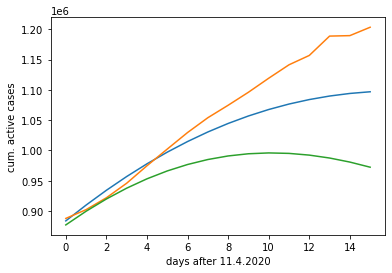

In [281]:
# World plot
G.items()
    
a=np.sum([x[0] for x in G.values()],axis=0)
t=np.sum(np.array([x[1] for x in G.values()]),axis=0)
b=np.sum([x[2] for x in G.values()],axis=0)

ch1=median_absolute_error(t,a)
ch2=median_absolute_error(t,b)
#print(t)
print(ch1,ch2, ch1/ch2)
print(np.abs((a-t)/(b-t)))
plt.plot(a)
plt.plot(t)
plt.plot(b)
plt.xlabel("days after 11.4.2020")
plt.ylabel("cum. active cases")
plt.show()

-4.784130214778633
-4.132033278927059
-3.8683209774433784
-0.01296488414282626
-8.289959020139163
-9.630916960954579
-14.908572442109488
-13.076614966607623
-5.568507884328269
-6.199741786887274
-24.131601906993964
-19.949297337912274
-13.481355035189761
-11.02979883007164
-7.974168492236159
-5.916849252116955
3.4706647518959683
1.9954619338047062
7.063363342629387
0.8315630295556167
-0.478857884262077
0.1548214727077708
3.2670850159143954
4.260576682332453
-7.9080520667553795
-7.878076699452775
-6.092355909504138
-3.753330370056836
-1.5803371177225052
-1.5628070396058256
1.9230095770095803
1.745250926958018


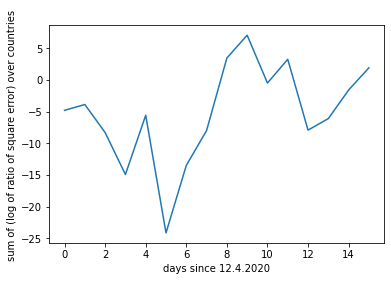

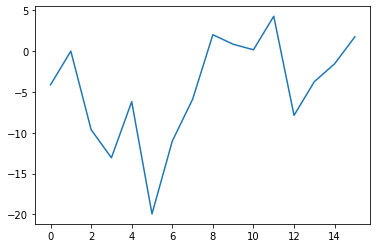

In [392]:
#all_days
crv=[]
crv2=[]
crvr=[]
reg=1 # how much outliers throw away
for day in range(16):
    try:
        a=np.array([x[0][day] for x in G.values()])
    except:
        break
    t=np.array([x[1][day] for x in G.values()])
    b=np.array([x[2][day] for x in G.values()])
    errors=np.square((b-t)/(a-t))
   
    print(np.sum(np.log(errors)))
    crv.append(np.sum(np.log(errors)))
    #crv2.append(np.prod(errors))
    errors.sort()
    if(reg):
        errors=errors[reg:-reg]
    print(np.sum(np.log(errors)))
    crvr.append(np.sum(np.log(errors)))
    

plt.plot(crv)
plt.xlabel("days since 12.4.2020")
plt.ylabel("sum of (log of ratio of square error) over countries ")
plt.show()
plt.plot(crvr)
plt.show()
#plt.plot(crv2)
#plt.show()

99482238.46153544 1980439023.3358598 0.05023241679714387
[1.97850048e+00 6.61836345e-01 5.72037828e-01 3.20025607e+00
 1.78745397e+01 9.99756353e-01 2.81908485e-02 6.77321553e+00
 1.78332752e-01 7.42239574e-02 2.71909377e-01 4.06041731e+00
 4.39723891e-01 6.00147622e-03 1.62975234e+01 9.66757203e-01
 3.82788029e-02 1.02992846e+01 5.43683570e-02 8.84470733e-01
 6.74112326e-01 2.84064716e-01 6.69681334e+01]
-6.718509420398952
0.0012083379962337883


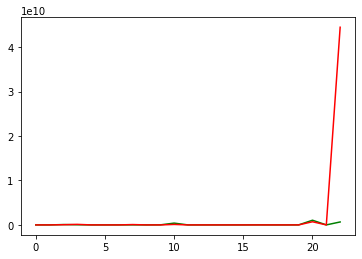

In [274]:
#last_day
    
a=np.array([x[0][-1] for x in G.values()])
t=np.array([x[1][-1] for x in G.values()])
b=np.array([x[2][-1] for x in G.values()])

ch1=mean_squared_error(t,a)
ch2=mean_squared_error(t,b)
#print(t)
print(ch1,ch2, ch1/ch2)
errors=np.square((b-t)/(a-t))
print(errors)
print(np.sum(np.log(errors)))
print(np.prod(errors))

plt.plot(np.square(a-t),'g')
plt.plot(np.square(b-t),'r')

plt.show()

Australia
569.651520395148 380.24934981086824 1.4980999196408524
[0.72067746 0.79421618 0.66408597 0.7479811  0.73541373 1.4265512
 1.42687198 1.88489384 2.17700716 1.69754015 1.66937778 1.82365749
 2.13536309 1.94529954 1.96434535 2.39036118]


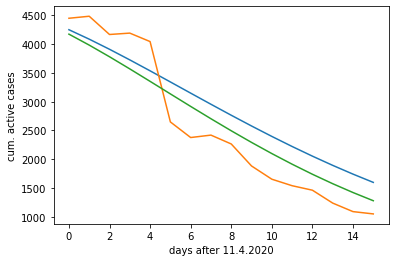

Austria
580.1397404142306 889.1265601412106 0.6524827470254551
[0.6168192  0.70018474 0.78438195 0.77827637 0.64166578 0.46516448
 0.3843484  0.52457288 0.6514194  0.66335012 0.65352539 0.64536496
 0.69726264 0.72291053 0.75405371 0.79036118]


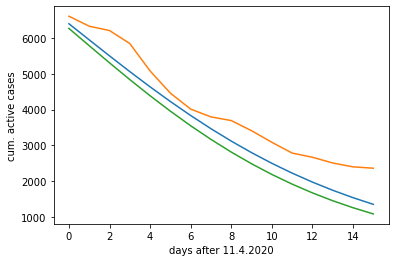

Belgium
3758.921633710381 4484.676741328289 0.8381700288607756
[0.83762928 0.75426331 0.48225389 0.86389414 0.83914787 0.83620448
 0.82145656 0.82589309 0.84735181 0.84867728 0.83950031 0.83403991
 0.84393434 0.84380534 0.84056086 0.83963854]


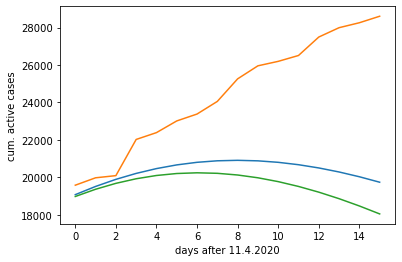

Canada
1913.2371166488574 3466.838526445472 0.5518679632911797
[ 1.37930685  1.85944266 11.82937469  5.67162989  0.30761895  0.48180594
  0.56024755  0.48738402  0.55904402  0.580969    0.59127848  0.61937772
  0.63572791  0.62313126  0.62345712  0.60162493]


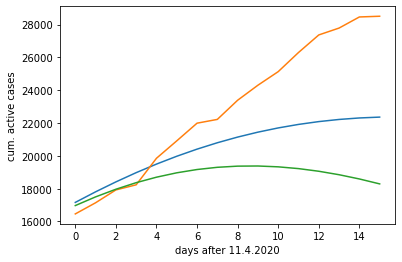

Chile
572.253709753044 169.35314945230311 3.379055610148038
[ 2.58788916  1.75284475  2.02777768  2.19549353  3.63476559  7.20191942
 11.45374098 34.52853386 11.29431071  7.41131538  4.72618573  2.49366667
  2.62426375  1.47218325  0.77973163  0.45275218]


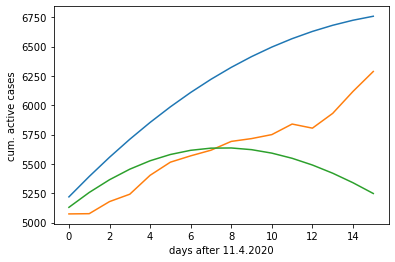

Croatia
57.61783983128328 28.749388988022588 2.0041413699361645
[ 2.13762129  0.12826191  0.64037898  0.29105086  0.20065634 22.53506998
  1.22104955  2.70854302  1.91689461  2.79387532  3.1849715   2.61663909
  4.2813699   3.10684955  2.40702988  2.06686246]


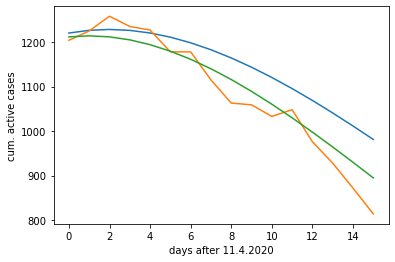

Czechia
885.9311999010497 344.25142515197876 2.5735004568533952
[2.60628721 2.13263712 1.71547829 1.65544651 1.9436134  1.91097715
 2.13908325 2.81808442 2.7308543  2.97699275 2.88661436 3.02419259
 3.07827778 3.99413079 5.27865002 4.23166084]


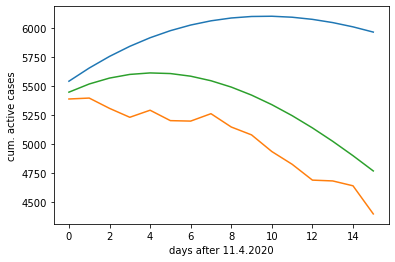

Germany
1342.1687559215934 3627.5035309881932 0.3699979185288247
[0.27147803 1.67453057 6.29477477 8.76299063 2.42950426 7.31793969
 0.39691101 0.08101456 0.13222446 0.03872849 0.06433751 0.14643905
 0.53024073 0.25636533 0.34963287 0.37660751]


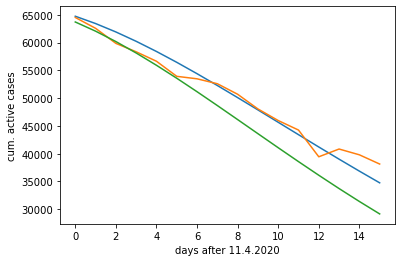

Iceland
226.4257132789458 164.33909224020877 1.3777958134756347
[1.23286266 1.30861142 1.33647454 1.26406376 1.27298806 1.26138224
 1.25868463 1.39210525 1.34496515 1.34431155 1.36243054 1.36463197
 1.38123068 1.40534528 1.40266088 1.4415068 ]


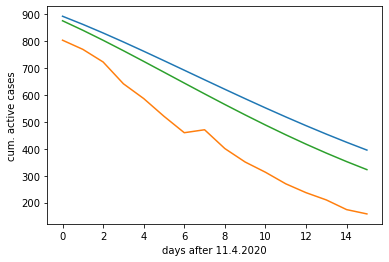

Israel
1928.7133275676365 1486.4281152518488 1.2975490087799169
[1.4290169  1.29064746 1.27431538 1.2661244  1.27770953 1.30032822
 1.30189856 1.30098476 1.29455635 1.31249244 1.31030617 1.29549492
 1.28655357 1.28337437 1.27370354 1.28498598]


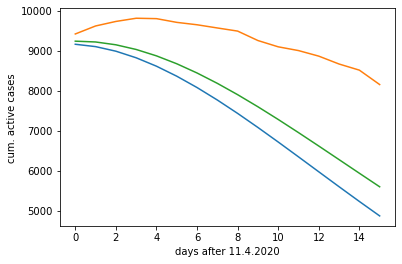

Italy
11606.955172113492 14460.146925977693 0.8026858393299978
[0.81333791 0.81660606 0.80040999 0.80501697 0.81174525 0.80337919
 0.80632009 0.80560752 0.80001995 0.79036423 0.78963856 0.7808183
 0.7800772  0.7769048  0.7840358  0.78631765]


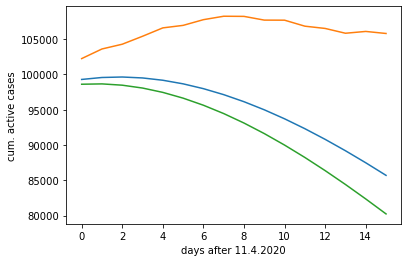

Jordan
11.715599643333618 33.35878542508068 0.3511998261940702
[0.14279005 0.62844923 2.26544452 3.36953533 2.30118138 0.50165535
 0.08463829 0.2088433  0.37572602 0.28506515 0.19156941 0.29784327
 0.33144328 0.37278499 0.41899076 0.44706869]


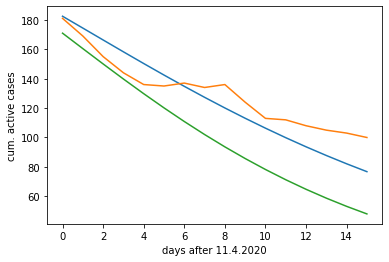

Korea
930.9230092984367 756.151562555977 1.2311328249480693
[1.273805   1.2511494  1.23646788 1.22258515 1.2292683  1.21587445
 1.21475212 1.21593209 1.20799626 1.20806458 1.19989399 1.23300993
 1.24632372 1.24391099 1.23035468 1.230372  ]


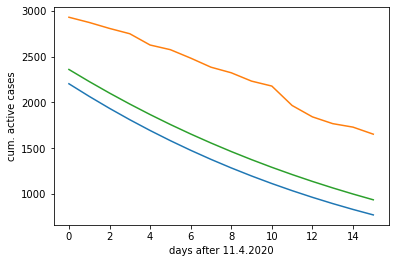

Latvia
39.766216578268825 31.933022794666897 1.2453007294038616
[ 0.39422498  0.1782328   0.04323674  1.95692808  2.78448278 13.5908187
  1.28732229  0.52378898  0.24431521  1.21432407  0.66800684  0.29565737
 14.32374776  5.55952701  2.5613377   1.64014465]


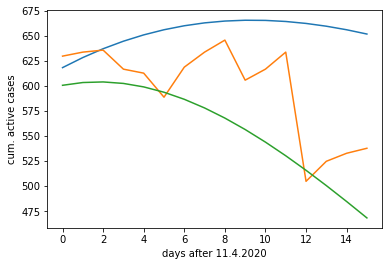

Lithuania
84.40823476674109 40.56427829434034 2.080851387377401
[ 1.21673049  1.26018041  1.31206652  1.293771    1.33399321  1.35949496
  2.30223755  3.73305803  0.40189195  2.20059747 21.337201   17.57675312
 13.39565163 23.35555196  4.86374578  1.78917567]


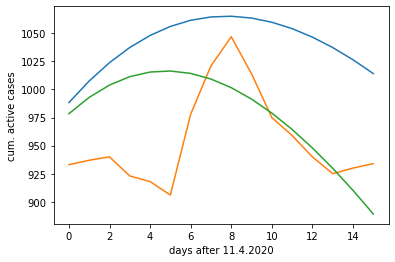

Malaysia
197.97671430050286 74.72193857347543 2.649512553877718
[ 0.65429418  0.9410684   1.05603224  3.7857688   1.3736655  20.12835421
 40.25147161  4.73883359  4.37354602  1.63543761  1.47819268  0.96656358
  0.74780261  0.6807069   0.69092322  0.66587837]


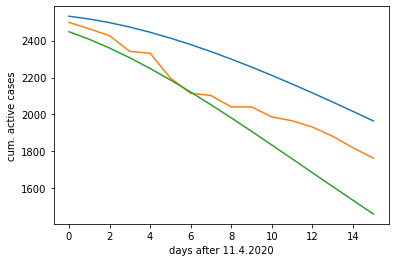

Netherlands
2008.6400124913744 2755.9578534721095 0.728835533519055
[0.87580441 0.84005731 0.78665244 0.67834904 0.67850016 0.72074886
 0.73347777 0.74011792 0.71848484 0.71304727 0.68787763 0.68526318
 0.67939685 0.66483063 0.65629392 0.63620832]


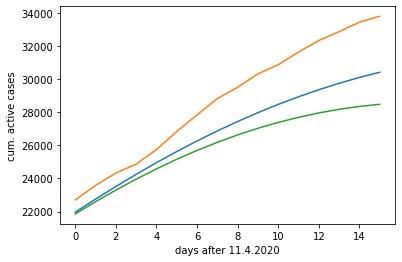

Norway
138.56338276248607 456.0875673919636 0.3038087259313607
[9.70293448e+00 5.35898110e+01 8.93309716e+00 3.37678777e+00
 4.82464367e-01 5.10471748e-01 1.91255496e-01 1.43573327e-01
 4.23451862e-02 5.98255171e-03 1.65137564e-01 2.04372251e-01
 2.40412962e-01 2.58578878e-01 2.74027743e-01 3.09380408e-01]


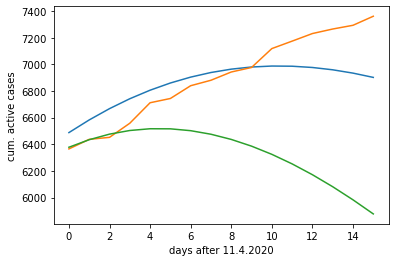

NZ
227.19370954845408 98.2914450665987 2.311429131950557
[1.96433146 1.67137384 1.54684578 1.47203935 1.62844013 1.74791934
 1.89309365 2.06215896 2.07985988 2.3415813  2.72100768 2.53058908
 2.99354586 3.84271098 3.68992386 3.81772182]


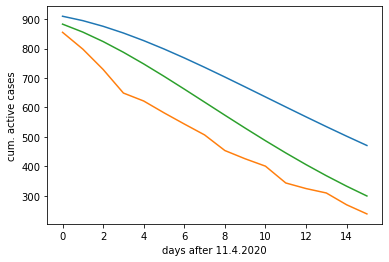

Portugal
489.4038380692218 320.3561295640966 1.5276868238330439
[1.1100287  0.64838493 0.61173033 0.28520174 1.95554932 0.359184
 7.0997247  2.23302715 1.42813691 1.5822824  1.4994425  1.47790785
 1.39142922 1.29840804 1.26383344 1.27591544]


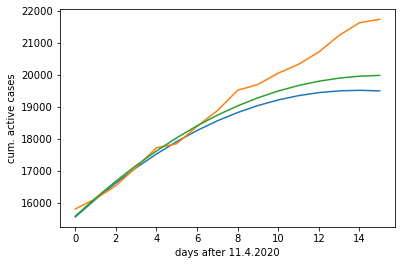

Spain
27174.097141382685 32271.129499854847 0.842055966510404
[0.56748018 0.63759816 0.62046912 0.69733881 0.7691928  0.82653031
 0.82891045 0.84832671 0.83595576 0.84259924 0.84403366 0.84774164
 0.85858269 0.86042699 0.79223557 0.7973384 ]


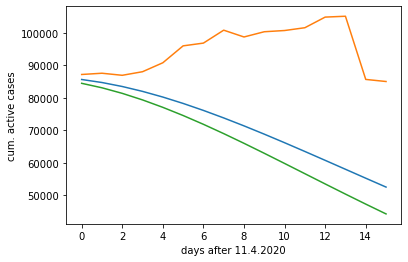

Switzerland
1603.2584771347688 1527.2290193722347 1.0497826172749034
[1.03449296 1.05590582 1.02889951 1.07457693 1.04951842 1.04038744
 1.03968161 1.03852319 1.04317143 1.05213008 1.0483839  1.0512386
 1.04652663 1.03932625 1.03851022 1.03810267]


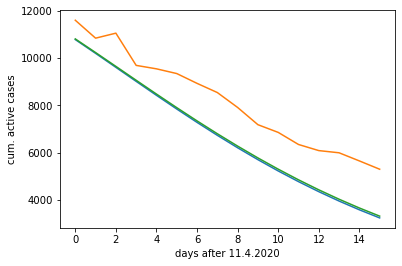

USA
20621.276333291433 13896.0470060613 1.4839670824585338
[ 6.11424315  1.46745617  1.55981127  1.78196083  2.40604158  4.8248837
 10.72173664  4.28538176  1.569381    0.75055945  0.29974541  0.09349649
  0.07086836  0.13788684  0.19111014  0.21621676]


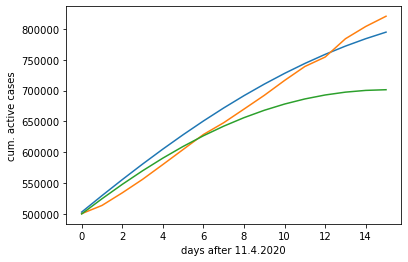

In [280]:
# Per country plot
G.items()
w=None

for c,w in G.items():    
    print(c)
    a=w[0]
    t=w[1]
    b=w[2]
    
    ch1=median_absolute_error(t,a)
    ch2=median_absolute_error(t,b)
    #print(t)
    print(ch1,ch2, ch1/ch2)
    print(np.abs((a-t)/(b-t)))
    plt.xlabel("days after 11.4.2020")
    plt.ylabel("cum. active cases")
    plt.plot(a)
    plt.plot(t)
    plt.plot(b)
    plt.show()

In [193]:
def cntr(country_name):
    return create_report(data_dir / f"{country_name}.data", short_name=country_name)

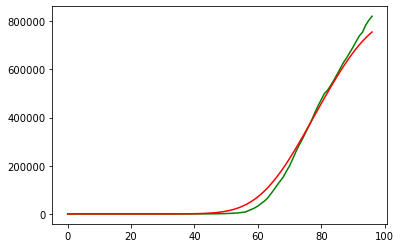

2020-01-22       1        2        2       2
2020-01-23       1        3        1      -1
2020-01-24       2        3        0      -1
2020-01-25       2        4        1       1
2020-01-26       5        4        0      -1
2020-01-27       5        4        0       0
2020-01-28       5        5        1       1
2020-01-29       5        5        0      -1
2020-01-30       5        6        1       1
2020-01-31       7        6        0      -1
2020-02-01       8        6        0       0
2020-02-02       8        7        1       1
2020-02-03      11        7        0      -1
2020-02-04      11        8        1       1
2020-02-05      11        8        0      -1
2020-02-06      11        9        1       1
2020-02-07      11        9        0      -1
2020-02-08      11        9        0       0
2020-02-09       8       10        1       1
2020-02-10       8       11        1       0
2020-02-11       9       12        1       0
2020-02-12       9       13        1       0
2020-02-13

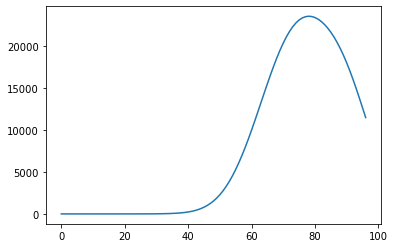

second derivation


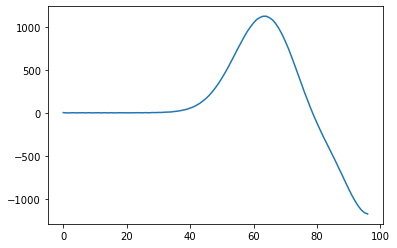

In [393]:
# print country data with smoothed version and calculated first and second oerder dreivation
from scipy.ndimage.filters import gaussian_filter1d
_=cntr("USA")
sigma=7.68 # higher value more smoother
last=0
last_dif=0
values=_.cumulative_active
plt.plot(values,'g')
values2=gaussian_filter1d(values,sigma,mode='nearest')
plt.plot(values2,'r')
plt.show()
dfs=[]
sdfs=[]
for d,v1,v in zip(_.dates,values, values2):
    
    dif=v-last
    dfs.append(dif)
    sdfs.append(dif-last_dif)
    print(d,f'{v1:7}', f' {v:7} ',f'{dif:7}',f'{dif-last_dif:7}')
    last_dif=dif
    last=v
print("derivation")
plt.plot(dfs)
plt.show()
print("second derivation")
plt.plot(sdfs)
plt.show()

In [275]:

country_name="USA"
country_report = create_report(data_dir / f"{country_name}.data", short_name=country_name)

In [276]:
country_report

CountryReport(short_name='USA', long_name='United States', dates=[datetime.date(2020, 1, 22), datetime.date(2020, 1, 23), datetime.date(2020, 1, 24), datetime.date(2020, 1, 25), datetime.date(2020, 1, 26), datetime.date(2020, 1, 27), datetime.date(2020, 1, 28), datetime.date(2020, 1, 29), datetime.date(2020, 1, 30), datetime.date(2020, 1, 31), datetime.date(2020, 2, 1), datetime.date(2020, 2, 2), datetime.date(2020, 2, 3), datetime.date(2020, 2, 4), datetime.date(2020, 2, 5), datetime.date(2020, 2, 6), datetime.date(2020, 2, 7), datetime.date(2020, 2, 8), datetime.date(2020, 2, 9), datetime.date(2020, 2, 10), datetime.date(2020, 2, 11), datetime.date(2020, 2, 12), datetime.date(2020, 2, 13), datetime.date(2020, 2, 14), datetime.date(2020, 2, 15), datetime.date(2020, 2, 16), datetime.date(2020, 2, 17), datetime.date(2020, 2, 18), datetime.date(2020, 2, 19), datetime.date(2020, 2, 20), datetime.date(2020, 2, 21), datetime.date(2020, 2, 22), datetime.date(2020, 2, 23), datetime.date(2020,